# Fifteeen years of flu in the US

**Note**: this exercise is based on the following tutorials:
* https://github.com/reconhub/phylo-practical
* https://grunwaldlab.github.io/Population_Genetics_in_R/DAPC.html

In this exercise you will learn:
* how to align DNA sequences
* how to calculate and display a matrix of genetic distances
* how to generate a phylogenetic tree
* how to analyze a lot of influenza virus isolates and find the genetic basis of their evolutionaries trajectories

Our data:
* 80 isolates of seasonal influenza (H3N2) genotyped for the hemagglutinin (HA) segment sampled in the US from 1993 to 2008 (first part of the exercise / phylogenetic tree)
* 1903 isolates of seasonal influenza (H3N2) genotyped for the hemagglutinin (HA) segment sampled worldwide (second part of the exercise / DAPC)


## Installing the required packages / downloading the required files

The required packages are: `seqinr` (to read/manage/write sequence data), `msa` (to perform multiple alignments) and `adegenet`, `ade4` (genomic analyses), `ape` (to generate/manipulate phylogenetic trees)

In [210]:
# We tell R to use /bin/tar to decompress the files. Otherwise it will try to use /bin/gtar
# and the installation will fail

#if (file.exists(Sys.getenv("TAR")) == FALSE)  {
#    Sys.setenv(TAR = "/bin/tar")
#}


# We install the required packages

#install.packages("seqinr",dep=TRUE,repos="https://cran.r-project.org")
#source("http://www.bioconductor.org/biocLite.R")
#biocLite("msa")
#install.packages(c("adegenet","ade4","ape"), dep=TRUE,repos="https://cran.r-project.org")

We download from github some data files that are needed for this tutorial (so you can learn how to download files from the Internet with `R`):

In [211]:
if (!dir.exists("data")) dir.create("data")
download.file("https://raw.githubusercontent.com/reconhub/phylo-practical/master/data/usflu.annot.csv", destfile = "data/usflu.annot.csv", method = "curl")
download.file("https://raw.githubusercontent.com/reconhub/phylo-practical/master/data/usflu.fasta", destfile = "data/usflu.fasta", method = "curl")
system("cat data/usflu.fasta |sed 's/> />/g'| tr -d '-' > data/usflu_formatted.fasta")

## Multiple sequence alignment
We load `seqinr` and `msa` and read the `.fasta` file containing the sequences we want to align:

In [212]:
library("seqinr")
library("msa")

sequences = readDNAStringSet("data/usflu_formatted.fasta")
sequences

  A DNAStringSet instance of length 80
     width seq                                              names               
 [1]  1701 ATGAAGACTATCATTGCTTTGAG...TAGGTGCAACATTTGCATTTGA CY013200
 [2]  1701 ATGAAGACTATCATTGCTTTGAG...TAGGTGCAACATTTGCATTTGA CY013781
 [3]  1701 ATGAAGACTATCATTGCTTTGAG...TAGGTGCAACATTTGCATTTGA CY012128
 [4]  1701 ATGAAGACTATCATTGCTTTGAG...TAGGTGCAACATTTGCATTTGA CY013613
 [5]  1701 ATGAAGACTATCATTGCTTTGAG...TAGGTGCAACATTTGCATTTGA CY012160
 ...   ... ...
[76]  1701 ATGAAGACTATCATTGCTTTGAG...TAGGTGCAACATTTGCATTTGA FJ549055
[77]  1701 ATGAAGACTATCATTGCTTTGAG...TAGGTGCAACATTTGCATTTGA EU779498
[78]  1701 ATGAAGACTATCATTGCTTTGAG...TAGATGCAACATTTGCATTTGA EU779500
[79]  1701 ATGAAGACTATCATTGCTTTGAG...TAGGTGCAACATTTGCATTTGA CY035190
[80]  1701 ATGAAGACTATCATTGCTTTGAG...TAGGTGCAACATTTGCATTTGA EU852005

We perform the multiple sequence alignment:

In [213]:
alignment = msa(sequences, "Muscle")
alignment

MUSCLE 3.8.31   

Call:
   msa(sequences, "Muscle")

MsaDNAMultipleAlignment with 80 rows and 1701 columns
     aln                                                   names
 [1] ATGAAGACTATCATTGCTTTGAGCT...CATTAGATGCAACATTTGCATTTGA EU779500
 [2] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA CY035190
 [3] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA EU852005
 [4] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA EU779498
 [5] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA EU516212
 [6] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA FJ549055
 [7] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA EU199369
 [8] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA EU516036
 [9] -------------------------...CATTAGGTGCAACATTTGCATTTGA EU199254 
 ... ...
[73] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA CY013781
[74] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA CY013613
[75] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA CY012160
[7

We convert the alignment to a format that `seqinr` can manage and then we save it:

In [214]:
alignment_seqinr = msaConvert(alignment, "seqinr::alignment")

# We save the data
write.fasta(as.list(alignment_seqinr$seq),alignment_seqinr$nam,file="data/usflu_ali.fasta",as.string=TRUE)

## Distance matrix and phylogenetic tree
We load the libraries needed for the next steps of the analysis:

In [215]:
library(ade4)
library(ape)
library(adegenet)

We load the alignment (converting it to `DNAbin` format, which is suitable to perform fast caculations. The `adegenet` provides a function to do this) and calculate a distance matrix (using the `ape` package):

In [216]:
dna <- fasta2DNAbin(file="data/usflu.fasta")


 Converting FASTA alignment into a DNAbin object... 


 Finding the size of a single genome... 


 genome size is: 1,701 nucleotides 

( 30  lines per genome )

 Importing sequences... 
........................................................................................................................................................................................................................................................................................................................................................................
 Forming final object... 

...done.



We load the annotations and have a look at them:

In [217]:
annot = read.csv("data/usflu.annot.csv",
header = TRUE, row.names=1, stringsAsFactors=FALSE)
tail(annot,5)

,accession,year,misc
,<chr>,<int>,<chr>
76,FJ549055,2008,(A/Illinois/14/2008(H3N2))
77,EU779498,2008,(A/Mississippi/01/2008(H3N2))
78,EU779500,2008,(A/Indiana/02/2008(H3N2))
79,CY035190,2008,(A/Pennsylvania/PIT43/2008(H3N2))
80,EU852005,2008,(A/Texas/06/2008(H3N2))


How many strains do we have for each year?

In [218]:
table(annot$year)


1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 
   5    5    5    5    5    5    5    5    5    5    5    5    5    5    5    5 

We calculate the distances between all our isolates using the model `TN93`:

In [219]:
D = dist.dna(dna, model="TN93")

We make a plot of the distance matrix:

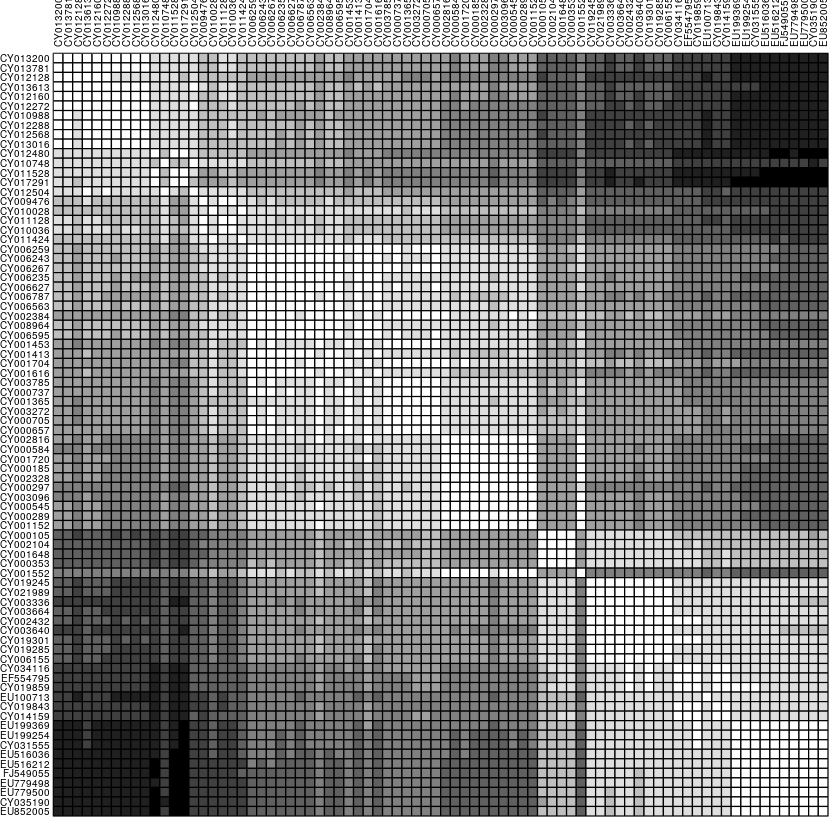

In [220]:
mat = as.data.frame(as.matrix(D))
table.paint(mat, cleg=0, clabel.row=.5, clabel.col=.5)

What are the max and min distances?

In [221]:
min(mat)
max(mat)

[1] 0

[1] 0.08361022

We generate a phylogenetic tree using the Neighbour-Joining algorithm and we display it (note that the tree is unrooted!):

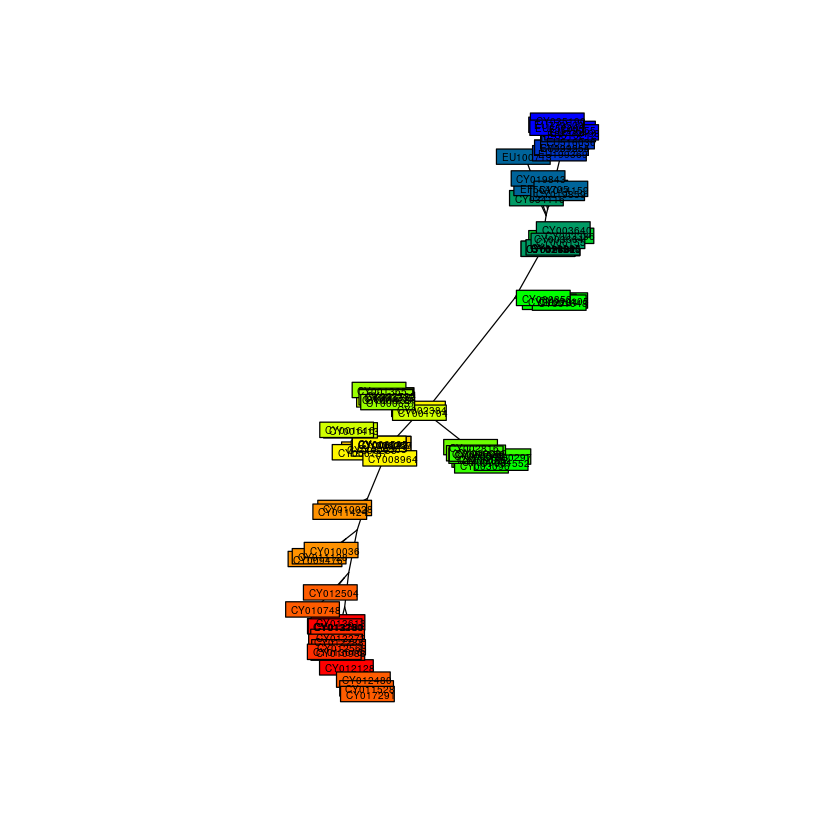

In [222]:
tre = nj(D)
plot(tre, type="unrooted", show.tip=FALSE)
myPal = colorRampPalette(c("red","yellow","green","blue"))
tiplabels(tre$tip.label, bg=num2col(annot$year, col.pal=myPal),
cex=.5)

We root the tree and display it again:

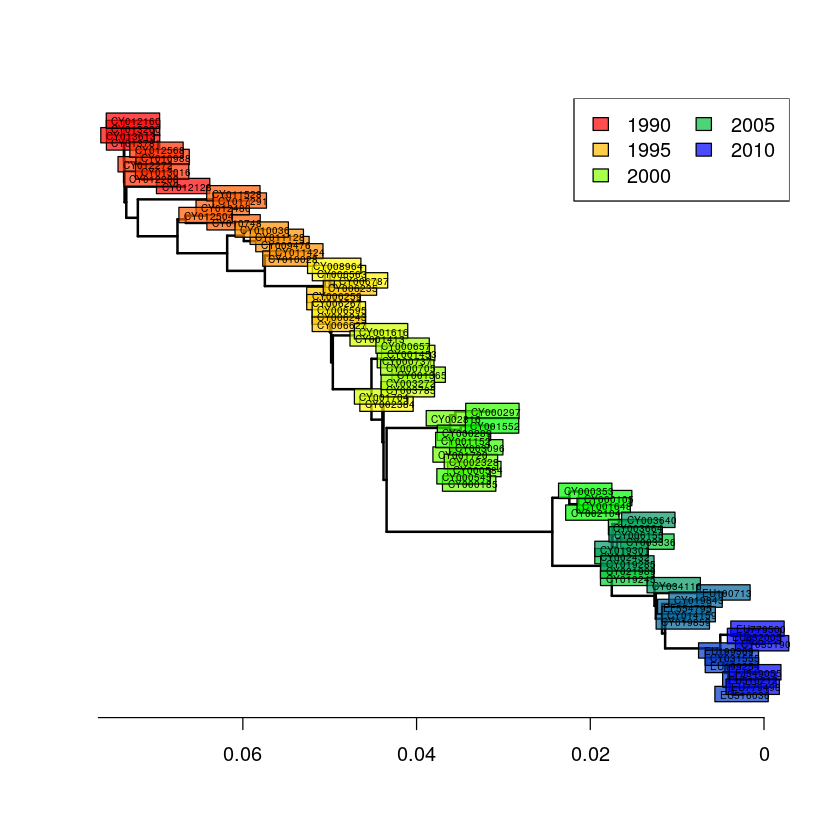

In [223]:
tre2 = root(tre, out=1)
tre2 = ladderize(tre2)
plot(tre2, show.tip=FALSE, edge.width=2)
tiplabels(tre$tip.label, bg=transp(num2col(annot$year, col.pal=myPal),.7),
cex=.5, fg="transparent")
axisPhylo()
temp = pretty(1993:2008, 5)
legend("topright", fill=transp(num2col(temp, col.pal=myPal),.7),
leg=temp, ncol=2)

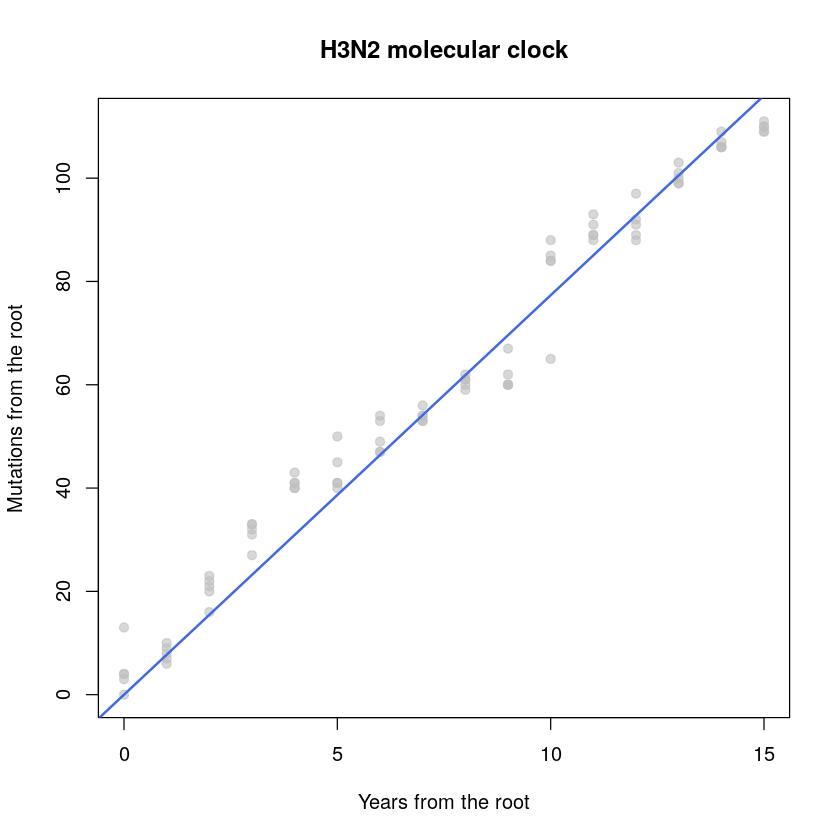

In [224]:
mutFromRoot = as.matrix(dist.dna(dna, model="N"))[1,]
yearFromRoot = annot$year-annot$year[1]
plot(mutFromRoot~yearFromRoot, xlab="Years from the root",
ylab="Mutations from the root", main="H3N2 molecular clock",pch=19,col=transp("grey",0.6))
lm.clock = lm(mutFromRoot~-1+yearFromRoot)
abline(lm.clock, col="royalblue",lwd=2)

In [225]:
summary(lm.clock)


Call:
lm(formula = mutFromRoot ~ -1 + yearFromRoot)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.327  -1.577   1.004   6.386  13.000 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
yearFromRoot  7.73274    0.07443   103.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.86 on 79 degrees of freedom
Multiple R-squared:  0.9927,	Adjusted R-squared:  0.9926 
F-statistic: 1.079e+04 on 1 and 79 DF,  p-value: < 2.2e-16


## Studying the genetic differences between groups of isolates

Our data set has just a few isolates (n = 80). 
Let's load bigger dataset of isolates (n = 1903) distributed worldwide:

In [226]:
data(H3N2)
pop(H3N2) = H3N2$other$epid

and perform a [DAPC analysis](https://bmcgenet.biomedcentral.com/articles/10.1186/1471-2156-11-94):

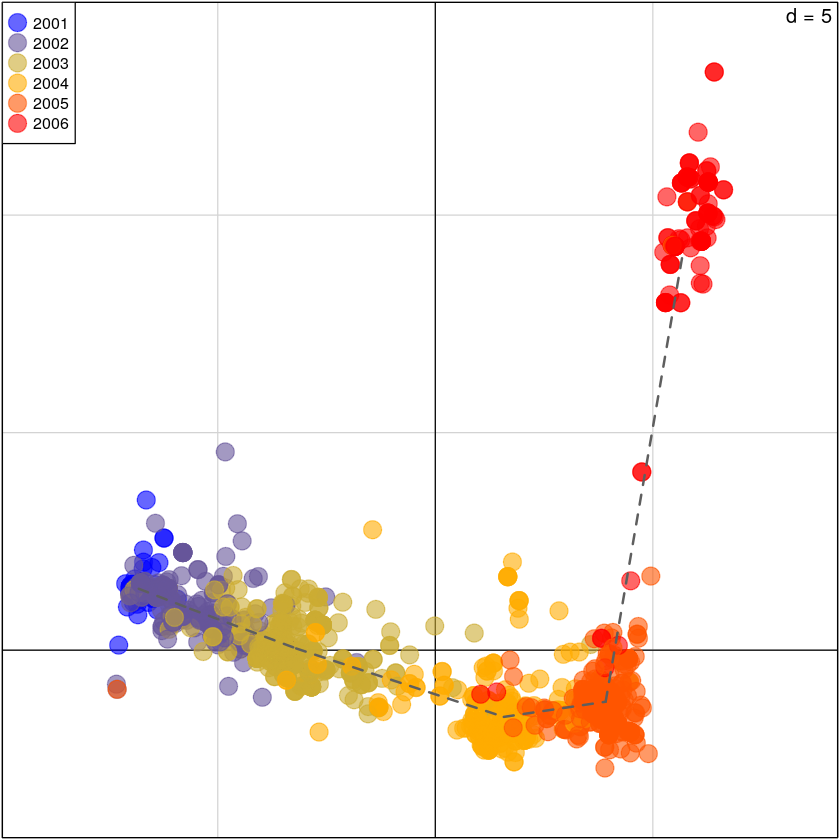

In [227]:
dapc_h3n2 = dapc(H3N2, var.contrib = TRUE, scale = FALSE, n.pca = 30, n.da =  nPop(H3N2) - 1)
scatter(dapc_h3n2,xax=1,yax=2,scree.da=F,cell=0, pch = 19, cstar = 0, solid=0.6,cex=2,clab=0,mstree=T,lty=2,lwd=2,leg=T,posi.leg="topleft",segcol="grey37",grid=T,cleg=0.8)

The graph shows that the cluster of strains sampled in 2006 is clearly separated from the other clusters by axis-2. We generate a loading plot to understand which SNP(s) contribute to this separation:

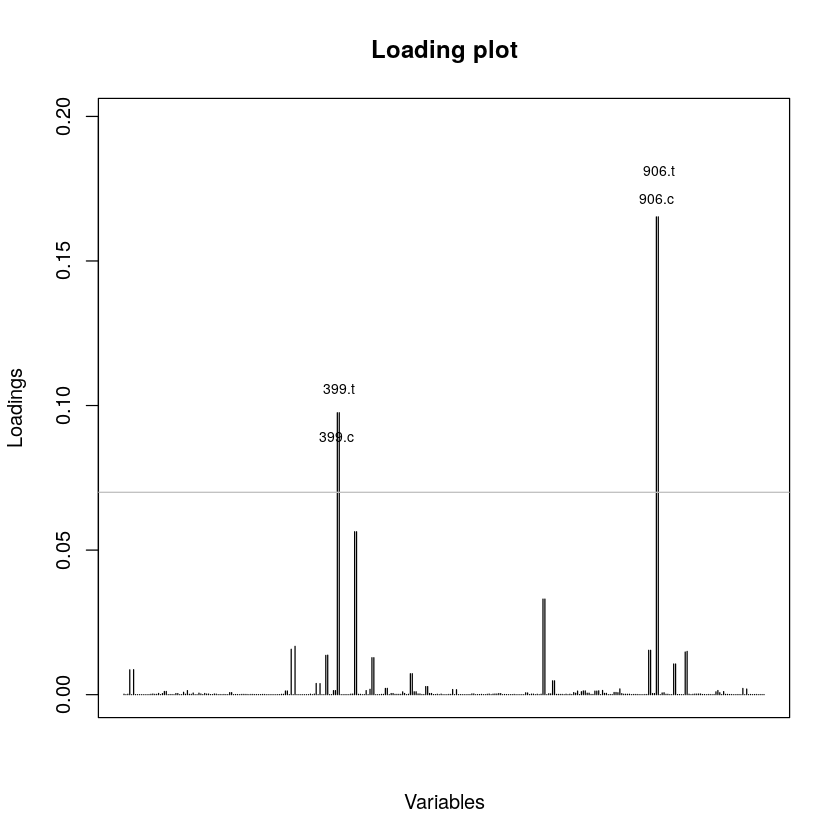

In [228]:
contrib = loadingplot(dapc_h3n2$var.contr, axis = 2, thres = 0.07, lab.jitter = 1)

Let's have a look at the raw numbers:

In [229]:
head(sort(dapc_h3n2$var.contr[,2],decreasing=TRUE))

906.c      906.t      399.c      399.t      424.a      424.g 
0.16524788 0.16524788 0.09750789 0.09750789 0.05634807 0.05634807

Now let's plot the allele frequencies of the position SNP 906:

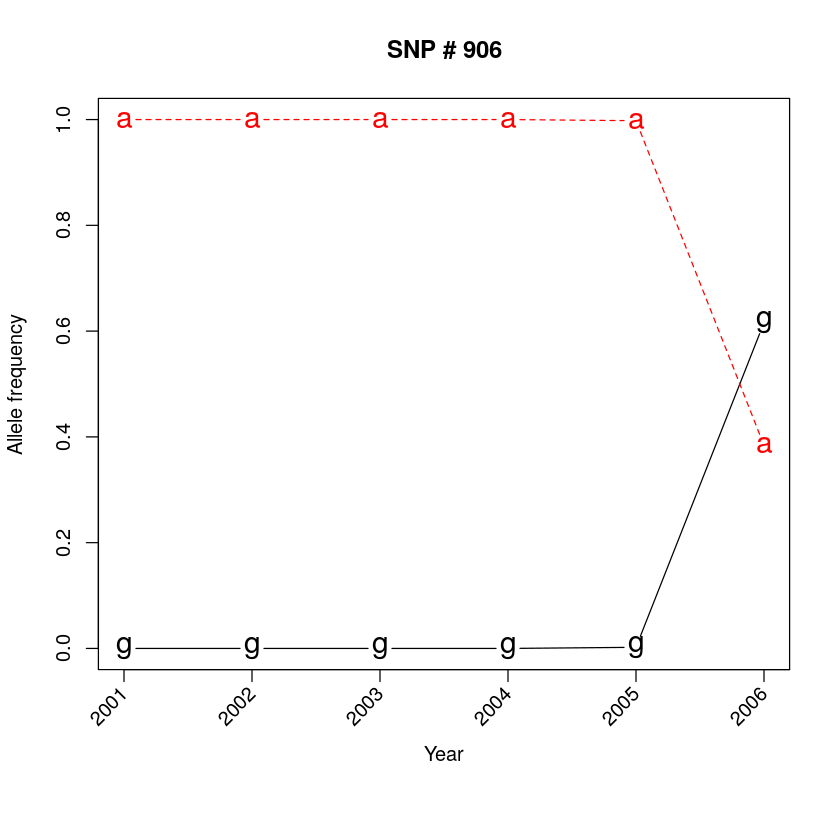

In [230]:
temp    = seploc(H3N2)  
snp906  = tab(temp[["906"]])
freq906 = apply(snp906, 2, function(e) tapply(e, pop(H3N2), mean, na.rm = TRUE))
                 par(mar = c(7, 4, 4, 2) + 0.1)
matplot(freq906,  pch = c("g", "a"), type = "b",
        xlab = "Year", ylab = "Allele frequency", main = "SNP # 906",
        xaxt = "n", cex = 1.5)
axis(side = 1, at=1:16, labels=FALSE)
text(1:16,par("usr")[3] - 0.04, srt = 45, adj = 1,
     labels = 2001:2006, xpd = TRUE)